## 1. Data Overview

Refer to the competition page for details: https://www.kaggle.com/c/petfinder-adoption-prediction/data

In [1]:
# Libraries
import glob
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import gensim
import lightgbm as lgb

%matplotlib inline

## 2. Data import



In [2]:
# Helper functions
def get_file_names(cat1='train',cat2='metadata'):
    path = '../input/petfinder-adoption-prediction/'+cat1+'_'+cat2+'/*.json'
    col_name = cat2+'_filename'
    fileNames = sorted(glob.glob(path))
    df_fileNames = pd.DataFrame({col_name:fileNames})
    df_fileNames['PetID'] = df_fileNames[col_name].apply(lambda x: x.split('/')[-1].split('-')[0])
    return df_fileNames


def parse_metadata(filename):
    with open(filename, 'r') as f:
        file = json.load(f)

        file_keys = list(file.keys())

        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations'][:int(len(file['labelAnnotations']) * 0.3)]
            file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']

        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
        file_crops = file['cropHintsAnnotation']['cropHints']

        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        file_crop_conf = np.asarray([x['confidence'] for x in file_crops]).mean()

        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.asarray([x['importanceFraction'] for x in file_crops]).mean()
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'annots_score': file_top_score,
            'color_score': file_color_score,
            'color_pixelfrac': file_color_pixelfrac,
            'crop_conf': file_crop_conf,
            'crop_importance': file_crop_importance,
            'annots_top_desc': ' '.join(file_top_desc)
        }

        df_metadata = pd.DataFrame(df_metadata,index=[0])

        return df_metadata
        
        
def parse_sentiment(filename):
    with open(filename, 'r') as f:
        file = json.load(f)
        
        file_sentiment_magnitude = file['documentSentiment']['magnitude']
        file_sentiment_score = file['documentSentiment']['score']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = ' '.join(file_entities)
        
        df_sentiment = {
            'sentiment_magnitude': file_sentiment_magnitude,
            'sentiment_score': file_sentiment_score,
            'entities': file_entities
        }
        
        df_sentiment = pd.DataFrame(df_sentiment,index=[0])

        return df_sentiment

In [3]:
# Tables from csv
df_train = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
df_test = pd.read_csv('../input/petfinder-adoption-prediction/test/test.csv')

# Labels from csv
df_breed = pd.read_csv('../input/petfinder-adoption-prediction/breed_labels.csv')
df_color = pd.read_csv('../input/petfinder-adoption-prediction/color_labels.csv')
df_state = pd.read_csv('../input/petfinder-adoption-prediction/state_labels.csv')

# Image metadata from json
train_metadata = get_file_names(cat1='train',cat2='metadata')
test_metadata = get_file_names(cat1='test',cat2='metadata')
train_metadata_parse = Parallel(n_jobs=6, verbose=1)(delayed(parse_metadata)(f) for f in train_metadata['metadata_filename'].values)
train_metadata_parse = pd.concat(train_metadata_parse, ignore_index=True, sort=False)
test_metadata_parse = Parallel(n_jobs=6, verbose=1)(delayed(parse_metadata)(f) for f in test_metadata['metadata_filename'].values)
test_metadata_parse = pd.concat(test_metadata_parse, ignore_index=True, sort=False)
df_train_metadata = pd.concat([train_metadata,train_metadata_parse],axis=1)
df_test_metadata = pd.concat([test_metadata,test_metadata_parse],axis=1)

# Sentiment data from json
train_sentiment = get_file_names(cat1='train',cat2='sentiment')
test_sentiment = get_file_names(cat1='test',cat2='sentiment')
train_sentiment_parse = Parallel(n_jobs=6, verbose=1)(delayed(parse_sentiment)(f) for f in train_sentiment['sentiment_filename'].values)
train_sentiment_parse = pd.concat(train_sentiment_parse, ignore_index=True, sort=False)
test_sentiment_parse = Parallel(n_jobs=6, verbose=1)(delayed(parse_sentiment)(f) for f in test_sentiment['sentiment_filename'].values)
test_sentiment_parse = pd.concat(test_sentiment_parse, ignore_index=True, sort=False)
df_train_sentiment = pd.concat([train_sentiment,train_sentiment_parse],axis=1)
df_test_sentiment = pd.concat([test_sentiment,test_sentiment_parse],axis=1)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  43 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 3094 tasks      | elapsed:    6.5s
[Parallel(n_jobs=6)]: Done 8594 tasks      | elapsed:   14.2s
[Parallel(n_jobs=6)]: Done 16294 tasks      | elapsed:   25.0s
[Parallel(n_jobs=6)]: Done 26194 tasks      | elapsed:   38.8s
[Parallel(n_jobs=6)]: Done 38294 tasks      | elapsed:   56.2s
[Parallel(n_jobs=6)]: Done 52594 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 58311 out of 58311 | elapsed:  1.4min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 328 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 6028 tasks      | elapsed:    8.6s
[Parallel(n_jobs=6)]: Done 14465 out of 14465 | elapsed:   20.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 692 tasks      | elapsed:    1.1s
[Paral

## 3. Data processing


### 3.1 Check data types for columns
From the output, we only need to encode annots_top_desc from metadata and entities from sentiment. 

We will apply LDA for encoding the text.

In [4]:
print(df_train.dtypes)
print(train_metadata_parse.dtypes)
print(train_sentiment_parse.dtypes)

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object
annots_score       float64
color_score        float64
color_pixelfrac    float64
crop_conf          float64
crop_importance    float64
annots_top_desc     object
dtype: object
sentiment_magnitude    float64
sentiment_score        float64
entities                object
dtype: object


In [5]:
# Helper functions
def encodeText(tokens,num_topics=3,passes=5,chunksize=100,alpha=1/50,seed=13):
    # Create Gensim dic from the tokens
    lda_dic = gensim.corpora.Dictionary(tokens)

    # Create corpus from the dic
    lda_corpus = [lda_dic.doc2bow(doc) for doc in tokens]

    # Create tf-idf from corpus
    tfidf = gensim.models.TfidfModel(lda_corpus)
    tfidf_corpus = tfidf[lda_corpus]

    # Train model
    lda_model = gensim.models.ldamodel.LdaModel(tfidf_corpus, num_topics=num_topics, \
                                                id2word = lda_dic, passes=passes,\
                                                chunksize=chunksize,update_every=0,\
                                                alpha=alpha, random_state=seed)
    # Topic distribution
    vec_lda = lda_model[tfidf_corpus]
    
    return vec_lda

def formatEncode(vec,num_topics):
    """vec: a list of tuples (topic_id,score)"""
    if len(vec)<num_topics:
        topic_ids = {x[0] for x in vec}
        topics_diff = set(range(num_topics))-topic_ids
        vec += [(x,0) for x in topics_diff]
    vec.sort(key=lambda x: x[0])
    vec=[x[1] for x in vec]
    return vec

def splitEncodeCol(df,col):
    col_names = [col+str(x) for x in range(len(df[col][0]))]
    return pd.concat([df,pd.DataFrame(list(df[col]),columns=col_names)],axis=1)

### 3.2 Encode metadata



In [6]:
df_train_metadata['annots_top_desc_encode'] = list(encodeText(df_train_metadata['annots_top_desc'].str.split()))
df_test_metadata['annots_top_desc_encode'] = list(encodeText(df_test_metadata['annots_top_desc'].str.split()))
df_train_metadata['annots_top_desc_encode'] = df_train_metadata['annots_top_desc_encode'].apply(lambda x: formatEncode(x,3))
df_test_metadata['annots_top_desc_encode'] = df_test_metadata['annots_top_desc_encode'].apply(lambda x: formatEncode(x,3))
df_train_metadata = splitEncodeCol(df_train_metadata,'annots_top_desc_encode')
df_test_metadata = splitEncodeCol(df_test_metadata,'annots_top_desc_encode')

### 3.3 Encode sentiment

In [7]:
sentiment_topics = 5
df_train_sentiment['entities_encode'] = list(encodeText(df_train_sentiment['entities'].str.split(),num_topics=sentiment_topics))
df_test_sentiment['entities_encode'] = list(encodeText(df_test_sentiment['entities'].str.split(),num_topics=sentiment_topics))
df_train_sentiment['entities_encode'] = df_train_sentiment['entities_encode'].apply(lambda x: formatEncode(x,sentiment_topics))
df_test_sentiment['entities_encode'] = df_test_sentiment['entities_encode'].apply(lambda x: formatEncode(x,sentiment_topics))
df_train_sentiment = splitEncodeCol(df_train_sentiment,'entities_encode')
df_test_sentiment = splitEncodeCol(df_test_sentiment,'entities_encode')

## 4. EDA

Adoption speed in terms of:

Type,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,State,VideoAmt,PhotoAmt

We show the distribution for cat and dog separately.

In [8]:
# Check for missing data
print(df_train.columns[np.sum(df_train.isnull())>0])
# Get index
cat_idx = df_train['Type']==1.0
dog_idx = df_train['Type']==2.0

Index(['Name', 'Description'], dtype='object')


In [9]:
# Helper functions
def getTop(col,top_num):
    df_train[cat_idx].groupby(col)['AdoptionSpeed'].mean().sort_values().head(top_num).plot.barh()
    plt.subplots()
    df_train[dog_idx].groupby(col)['AdoptionSpeed'].mean().sort_values().head(top_num).plot.barh()
    plt.show()
    
def barCol(col,c):
    d={}
    d.update({('cat'+str(x)): df_train.loc[df_train[col]==x & cat_idx].groupby('AdoptionSpeed').count()[col] for x in c})
    d.update({('dog'+str(x)): df_train.loc[df_train[col]==x & dog_idx].groupby('AdoptionSpeed').count()[col] for x in c})
    pd.DataFrame(d).plot.bar()
    plt.show()
    
def boxCol(col):
    fig,(ax1,ax2) = plt.subplots(1,2)
    temp=[df_train[col][df_train['AdoptionSpeed']==x & cat_idx] for x in df_train['AdoptionSpeed'].unique()]
    ax1.boxplot(temp, showfliers=False)
    temp=[df_train[col][df_train['AdoptionSpeed']==x & dog_idx] for x in df_train['AdoptionSpeed'].unique()]
    ax2.boxplot(temp, showfliers=False)
    plt.show()

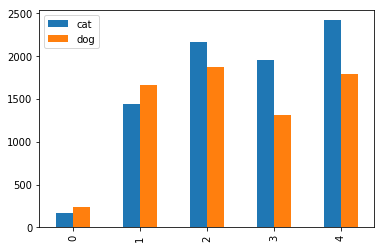

In [10]:
# Overall adoption
pd.DataFrame({'cat': df_train['AdoptionSpeed'][cat_idx].value_counts().sort_index(),\
           'dog': df_train['AdoptionSpeed'][dog_idx].value_counts().sort_index()}).\
            plot.bar()
plt.show()

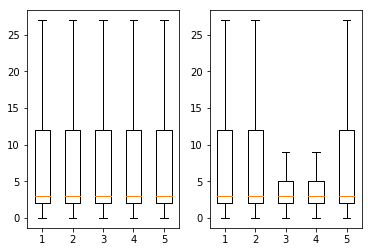

In [11]:
# Age
boxCol('Age')

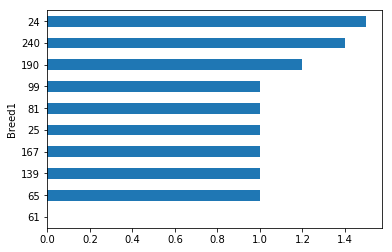

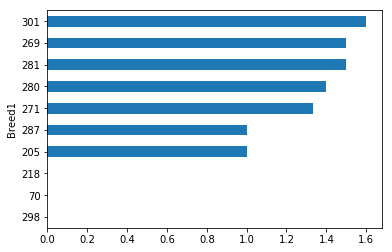

In [12]:
# Breed1 (top adoption)
getTop('Breed1',10)

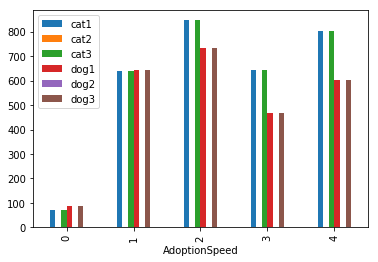

In [13]:
# Gender
barCol('Gender',[1,2,3])

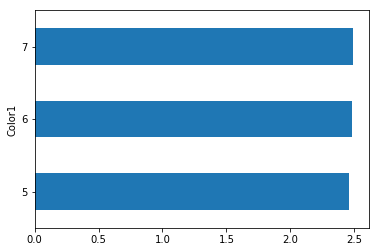

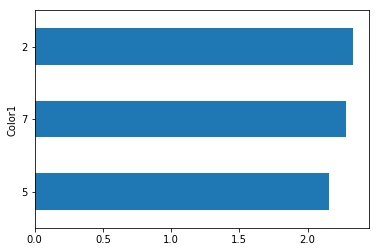

In [14]:
# Color1
getTop('Color1',3)

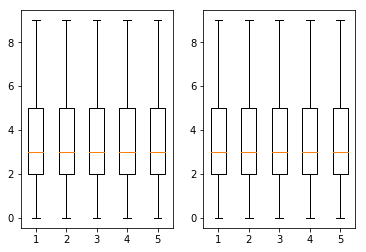

In [15]:
# PhotoAmt
boxCol('PhotoAmt')

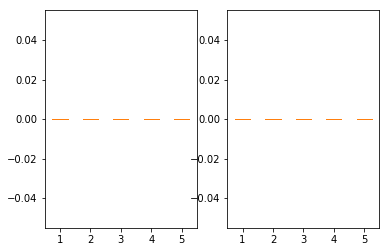

In [16]:
# PhotoAmt
boxCol('VideoAmt')

## 5. LGBM Model

### 5.1 Prepare data

In [17]:
# Merge data
dfTemp_train = df_train.merge(df_train_sentiment,on='PetID',how='left')
dfTemp_train = dfTemp_train.merge(df_train_metadata,left_on='PetID',right_on='PetID',how='left',suffixes=(False, False))
dfTemp_test = df_test.merge(df_test_sentiment,on='PetID',how='left')
dfTemp_test = dfTemp_test.merge(df_test_metadata,left_on='PetID',right_on='PetID',how='left',suffixes=(False, False))


In [18]:
# Remove unnecessary columns
remove_cols = ['Name','RescuerID','Description','PetID','sentiment_filename','entities','entities_encode',\
              'metadata_filename','annots_top_desc','annots_top_desc_encode']

X_train = dfTemp_train.drop(columns=remove_cols)
X_test = dfTemp_test.drop(columns=remove_cols)

In [19]:
# Convert to lgb dataset
n=1000
train_data = lgb.Dataset(data=X_train.iloc[:n].drop(columns=['AdoptionSpeed']),label=X_train['AdoptionSpeed'][:n])

### 5.2 Train Model

In [20]:
# Helper functions
def getRMSE(max_depth,min_data_in_leaf,mode='cv'):
    """p=(max_depth,min_data_in_leaf)"""
    
    params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 2*max_depth,
          'max_depth': max_depth,
          'min_data_in_leaf':min_data_in_leaf,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17}

    early_stop = 500
    verbose_eval = None if mode=='cv' else 500
    num_rounds = 10000
    nfold=5

    if mode=='cv':
        mdl=lgb.cv(params=params, train_set=train_data, num_boost_round=num_rounds, nfold=nfold, verbose_eval=verbose_eval,\
              early_stopping_rounds=early_stop)
        return [mdl['rmse-mean'][-1],(max_depth,min_data_in_leaf)]
    elif mode=='train':
        mdl=lgb.train(params=params, train_set=train_data, valid_sets=train_data,num_boost_round=num_rounds, verbose_eval=verbose_eval,\
              early_stopping_rounds=early_stop)
        return mdl
    
    

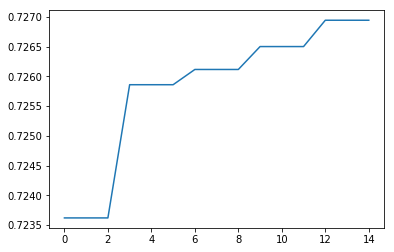

In [21]:
# Tuning params with CV
max_depth=range(7,10)
min_data_in_leaf=range(100,105)
p=[(x,y) for x in max_depth for y in min_data_in_leaf]

rmse_cv=[]

for x,y in p:
    rmse_cv.append(getRMSE(x,y))

rmse_cv.sort(key=lambda x: x[0])
plt.plot([x[0] for x in rmse_cv])
plt.show()

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.738472
[1000]	training's rmse: 0.647302
[1500]	training's rmse: 0.58387
[2000]	training's rmse: 0.536419
[2500]	training's rmse: 0.498799
[3000]	training's rmse: 0.468604
[3500]	training's rmse: 0.443567
[4000]	training's rmse: 0.423046
[4500]	training's rmse: 0.404654
[5000]	training's rmse: 0.38833
[5500]	training's rmse: 0.372724
[6000]	training's rmse: 0.358959
[6500]	training's rmse: 0.345804
[7000]	training's rmse: 0.336352
Early stopping, best iteration is:
[6961]	training's rmse: 0.336352


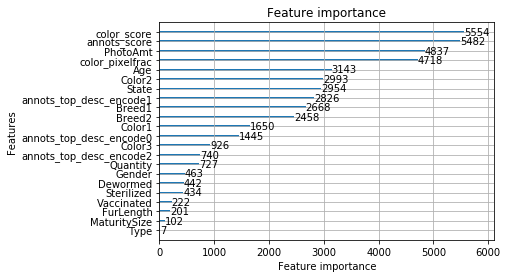

In [22]:
# Build model
mdl=getRMSE(rmse_cv[0][1][0],rmse_cv[0][1][1],'train')
lgb.plot_importance(mdl)

### 5.3 Predict

In [23]:
# Predict testing data
Y_test = mdl.predict(X_test, num_iteration=mdl.best_iteration)

## 6. Create submission file

In [24]:
submission = pd.DataFrame({'PetID': dfTemp_test['PetID'].values, 'AdoptionSpeed': Y_test.astype(np.int32)})
submission.head()
submission.to_csv('submission.csv', index=False)